In [241]:
import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
import wlcstat.wlcstruc as wlcstruc

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

pset=propagator.prop_set(nlam=10) 

In [98]:
# given a (set of) polymer structure, create a set of M^(2) connectivity matrices

poly = [1, 1, 0, 0]
n_p = 1
M = len(poly)
alph1 =1
alph2 =0

mat = np.zeros((M, M)) #MxM 

for j1,M1 in enumerate(poly):
    for j2,M2 in enumerate(poly):
#         print("M1 = ", M1)
#         print(M2)
#         print((M1 == alph1) * (M2 == alph2))
        mat[j1, j2] += (1/n_p) * (M1 == alph1) * (M2 == alph2)# TODO how to implement indicator vairalbe
        
#TODO consider multiple polymer types

In [99]:
mat

array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [221]:
#vectorized single poly


poly = np.array([1, 1, 0, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sub1 = 1*(poly == alph1)
sub2 = 1*(poly == alph2)
mat_Vect = np.outer(sub1, sub2)

In [222]:
mat_Vect

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [189]:
#vectorized multi poly. inly considering equal amounts of each polymer. TODO- consider unequal amounts. Manipulate simga?

poly_mat = np.array([[1, 0], [0, 1], [1, 1]]) #matrix where num rows = num polymers
# poly_mat = np.array([[0, 0],[1, 1]]) #matrix where num rows = num polymers

# poly_mat = np.array([1, 0])

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
mat_Vect_two = np.sum(prods, axis = 0) / n_p # averaging each contribution

In [229]:
# Have M. Now need to multiple upper triangle, lower triangle, and diagonal by sf components (construct C matrix, mat mul the)
#  (the debye func at diag, and the apprprt exp(-xm j(1or2) - j (2or1)) * 1/xm2 blah blah)
N_m = 1
b = 1
k = 1#np.array([1, 2, 3])

x_m = (1/6) * N_m * b**2 * k**2

C = np.zeros((M, M))
one = np.ones((M,M))
grid = np.indices((M, M))


#j1 = j2
debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
np.fill_diagonal(C, np.diag(one * debye))

integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

#j1 > j2
j1minusj2_mat = grid[0] - grid[1]
C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral, k = -1)

#j2 > j1
j2minusj1_mat = -1 * j1minusj2_mat
C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral, k = 1)
 
#isnt j2minusj1 and j1minusj2 the same?? since only done in special case where the one is bigger than the other?

In [230]:
S2_AA = np.sum(C * mat_Vect)

In [231]:
S2_AA

3.5902543613128177

In [ ]:
# compare to Vertex/wlcstat codebase at discrete ks


In [342]:
np.fill_diagonal(np.zeros((5,2,2)), 4)

ValueError: All dimensions of input must be of equal length

In [340]:
np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [341]:
np.diag(np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]]))

ValueError: Input must be 1- or 2-d.

In [345]:
one * debye

ValueError: operands could not be broadcast together with shapes (50,2,2) (50,) 

In [346]:
# # %%time
# # FULL S2_AA calculation vectorize attempt

# #Mono matrix:
# poly = np.array([1, 1])
# n_p = 1
# M = len(poly)
# alph1 =np.ones(M)
# alph2 =np.ones(M)
# sig1 = 1*(poly == alph1)
# sig2 = 1*(poly == alph2)
# monomer_mat = np.outer(sig1, sig2)

# #k-dependenece
# N_m = 1.
# b = 1.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


# one = np.ones((len(k_vec), M,M))
# grid = np.indices((M, M))
# S2_AA_arr = np.zeros(nk)

# k = k_vec
# C = np.zeros((len(k_vec), M, M))
# x_m = (1/6) * N_m * b**2 * k**2

# #j1 = j2
# debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

# np.fill_diagonal(C, np.diag(one * debye)) #FAIL

# integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

# #j1 > j2
# j1minusj2_mat = grid[0] - grid[1]
# C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

# #j2 > j1
# j2minusj1_mat = -1 * j1minusj2_mat
# C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
# S2_AA_arr[i] = np.sum(C * monomer_mat)

In [325]:
%%time
# FULL S2_AA calculation

#Mono matrix:
poly = np.array([1, 1])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)

Wall time: 15.6 ms


<timed exec>:38: RuntimeWarning: overflow encountered in multiply
<timed exec>:42: RuntimeWarning: overflow encountered in multiply
<timed exec>:34: RuntimeWarning: overflow encountered in exp
<timed exec>:38: RuntimeWarning: overflow encountered in exp
<timed exec>:38: RuntimeWarning: invalid value encountered in multiply
<timed exec>:42: RuntimeWarning: overflow encountered in exp
<timed exec>:42: RuntimeWarning: invalid value encountered in multiply


In [330]:
%%time
# FULL S2_AA calculation POLYDISPERSE

#Mono matrix:

poly_mat = np.array([[1, 1], [1, 1], [1, 1]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr_poly = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr_poly[i] = np.sum(C * monomer_mat)

Wall time: 15.6 ms


<timed exec>:53: RuntimeWarning: overflow encountered in multiply
<timed exec>:57: RuntimeWarning: overflow encountered in multiply
<timed exec>:49: RuntimeWarning: overflow encountered in exp
<timed exec>:53: RuntimeWarning: overflow encountered in exp
<timed exec>:53: RuntimeWarning: invalid value encountered in multiply
<timed exec>:57: RuntimeWarning: overflow encountered in exp
<timed exec>:57: RuntimeWarning: invalid value encountered in multiply


In [331]:
%%time
N = N_m * M
# b = 1
x = (1/6) * N * b**2 * (k_vec**2)
debye_arr = (2/(x**2)) * (x + np.exp(-x) - 1) #* (1/N**2)

Wall time: 0 ns


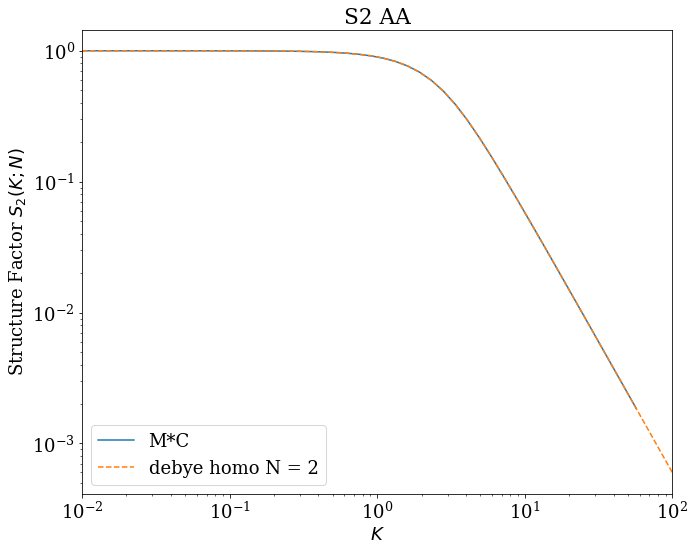

In [332]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "M*C")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Now derive conversion rules from AA to AB and BB (G_AA, GAB, G_BB in notes. Re derive!!!!!). 

In [360]:
%%time
# FULL S2_AB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AB_arr[i] = np.sum(C * monomer_mat)

Wall time: 15.6 ms


<timed exec>:40: RuntimeWarning: overflow encountered in multiply
<timed exec>:44: RuntimeWarning: overflow encountered in multiply
<timed exec>:36: RuntimeWarning: overflow encountered in exp
<timed exec>:40: RuntimeWarning: overflow encountered in exp
<timed exec>:40: RuntimeWarning: invalid value encountered in multiply
<timed exec>:44: RuntimeWarning: overflow encountered in exp
<timed exec>:44: RuntimeWarning: invalid value encountered in multiply


In [361]:
#S_AB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)

H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]

<ipython-input-361-786e2a4a37f8>:42: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-361-786e2a4a37f8>:46: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-361-786e2a4a37f8>:38: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-361-786e2a4a37f8>:42: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-361-786e2a4a37f8>:42: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-361-786e2a4a37f8>:46: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipyth

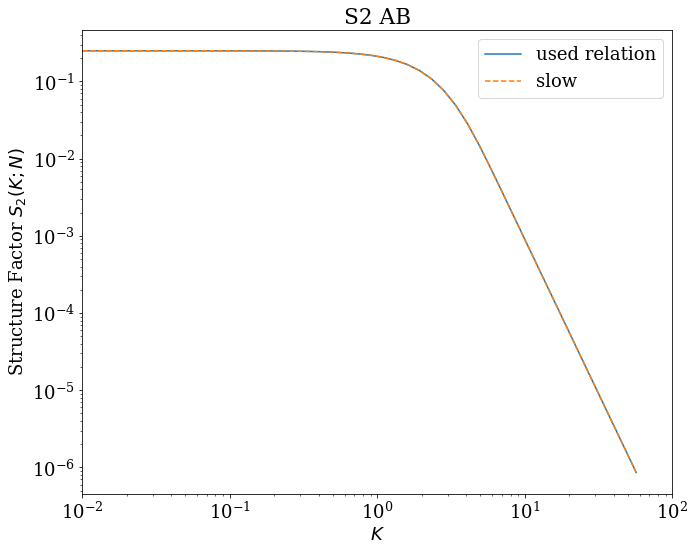

In [364]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_AB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [367]:
%%time
# FULL S2_BB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.zeros(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_BB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_BB_arr[i] = np.sum(C * monomer_mat)

Wall time: 15.6 ms


<timed exec>:40: RuntimeWarning: overflow encountered in multiply
<timed exec>:44: RuntimeWarning: overflow encountered in multiply
<timed exec>:36: RuntimeWarning: overflow encountered in exp
<timed exec>:40: RuntimeWarning: overflow encountered in exp
<timed exec>:40: RuntimeWarning: invalid value encountered in multiply
<timed exec>:44: RuntimeWarning: overflow encountered in exp
<timed exec>:44: RuntimeWarning: invalid value encountered in multiply


In [372]:
#S_BB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

<ipython-input-372-8b2001b9b08f>:44: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-372-8b2001b9b08f>:48: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-372-8b2001b9b08f>:40: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-372-8b2001b9b08f>:44: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-372-8b2001b9b08f>:44: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-372-8b2001b9b08f>:48: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipyth

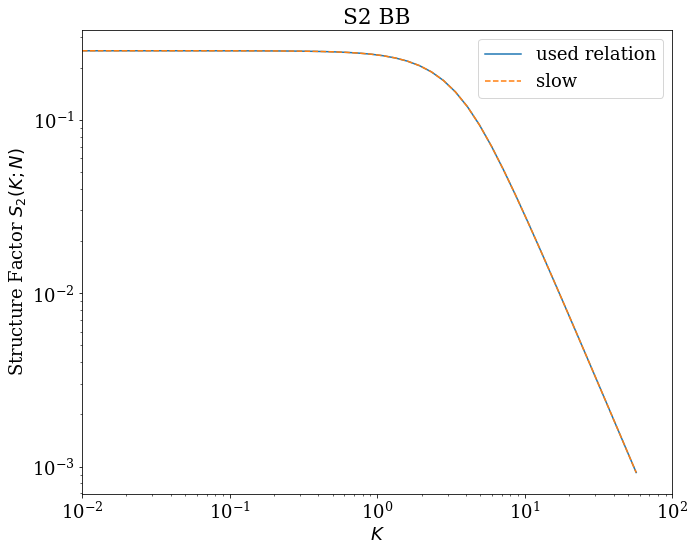

In [373]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

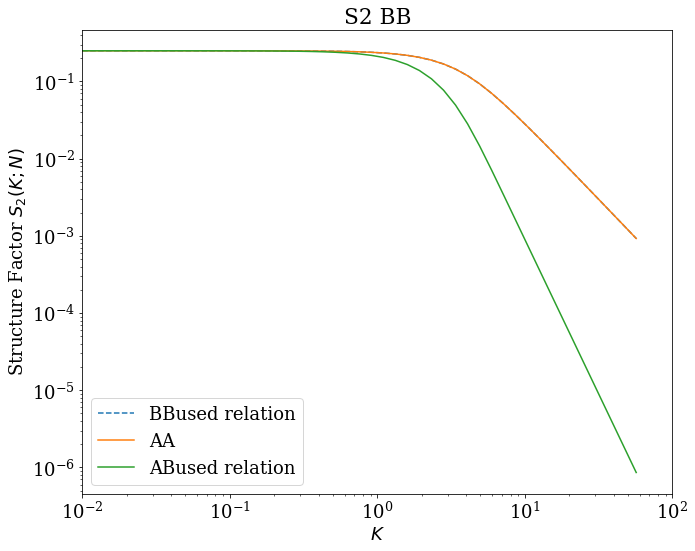

In [377]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "BBused relation", linestyle = "--")
plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_AB_arr_fast, label = "ABused relation")
# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# invert, stability analysis AB BA vs AA BB

In [418]:
#S_BB calc fast

#Mono matrix:

poly_mat = np.array([[1, 1], [0, 0]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

<ipython-input-418-c714ce7b4c47>:58: RuntimeWarning: overflow encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-418-c714ce7b4c47>:62: RuntimeWarning: overflow encountered in multiply
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipython-input-418-c714ce7b4c47>:54: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-418-c714ce7b4c47>:58: RuntimeWarning: overflow encountered in exp
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-418-c714ce7b4c47>:58: RuntimeWarning: invalid value encountered in multiply
  C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)
<ipython-input-418-c714ce7b4c47>:62: RuntimeWarning: overflow encountered in exp
  C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1)
<ipyth

In [401]:
min_eig

1.000010648719335

In [414]:
S2_AB_arr_fast

array([2.49995854e-01, 2.49993994e-01, 2.49991216e-01, 2.49987100e-01,
       2.49981253e-01, 2.49972708e-01, 2.49960248e-01, 2.49942113e-01,
       2.49915700e-01, 2.49877241e-01, 2.49821244e-01, 2.49739718e-01,
       2.49621045e-01, 2.49448332e-01, 2.49197051e-01, 2.48831626e-01,
       2.48300558e-01, 2.47529503e-01, 2.46411571e-01, 2.44793998e-01,
       2.42460376e-01, 2.39108139e-01, 2.34322548e-01, 2.27552089e-01,
       2.18097672e-01, 2.05141268e-01, 1.87858210e-01, 1.65672290e-01,
       1.38692149e-01, 1.08249748e-01, 7.72029872e-02, 4.94243846e-02,
       2.82144826e-02, 1.45804958e-02, 7.07756096e-03, 3.35363862e-03,
       1.58174859e-03, 7.45778479e-04, 3.51624594e-04, 1.65786297e-04,
       7.81660236e-05, 3.68542356e-05, 1.73762796e-05, 8.19268360e-06,
       3.86274083e-06, 1.82123068e-06, 8.58685929e-07,            nan,
                  nan,            nan])

In [419]:
det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) #@ chi = 0

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv)

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]//2][0]
    

In [420]:
min_eig

2.0000212974386704

In [421]:
k_star

0.01

In [400]:
#CLEAN UP< DEFINE FUNCTIONS!!!!

In [249]:
# s2AA_vert = s2wlc(pset, N, FA, K, sequence='all')[0][0]
# s2AA_vert

(613216.6657296097+7.508889980624683e-11j)

In [290]:
# s2 = wlcstruc.s2_wlc(k_vec, 100000, dimensions = 3, alpha_max = 25)
# N = 2.
# s2AA_stat = wlc_copoly.s2_wlc_diblock(k_vec, N, FA, dimensions=3, alpha_max=25)[0]
# s2AA_stat #* N**2